In [28]:
import json as json
import pathlib as pl
from copy import deepcopy
from datetime import datetime
from gc import collect
from os import path, system
from warnings import simplefilter

import matplotlib.pyplot as plt
from matplotlib import rcParams
from numpy import array, zeros
from numpy.linalg import norm
from scipy.spatial.transform import Rotation
from tqdm import tqdm

from catenary import Catenary
from utils import check, gif_from_pngs, print_dict

simplefilter( 'ignore', RuntimeWarning )

gain = 1.5
rcParams[ 'figure.figsize' ] = [ gain * 6.4, gain * 4.8 / 2 ]

In [29]:
files = list( pl.Path( "./export" ).glob( '*' ) )
files.sort( key = lambda x: path.getctime( x ) )
for v in files:
	print( str( v ).split( '//' )[ -1 ], end = '\t' )
	print( datetime.fromtimestamp( path.getctime( v ) ) )

export\three_robots_chain_1726157070	2024-09-17 09:04:31.536003
export\three_robots_chain_1726580899	2024-09-17 15:48:19.796810
export\three_robots_chain_with_fixed_end_1727078633	2024-09-23 10:03:53.983169
export\three_robots_chain_with_fixed_end_1727081819	2024-09-23 10:56:59.165230
export\three_robots_chain_with_fixed_end_1727099624	2024-09-23 15:53:44.695520
export\three_robots_chain_1726514783	2024-09-24 09:27:41.851908
export\three_robots_chain_with_fixed_end_1726429003	2024-09-24 09:27:41.884528
export\three_robots_chain_with_fixed_end_1726554218	2024-09-24 09:27:41.919829
export\three_robots_chain_with_fixed_end_1727163792	2024-09-24 09:43:12.977548
export\three_robots_chain_with_fixed_end_1727166337	2024-09-24 10:25:37.238871
export\three_robots_chain_with_fixed_end_1727173761	2024-09-24 12:29:21.839493
export\three_robots_chain_with_fixed_end_1727174240	2024-09-24 12:37:20.930869
export\three_robots_chain_with_fixed_end_1727175608	2024-09-24 13:00:08.731280
export\three_robot

In [30]:
folder = pl.Path( './export/chain_of_four_1727956939' )
uuid = str( folder ).split( '_' )[ -1 ]

In [31]:
with open( folder / 'config.json' ) as f:
	config = json.load( f )
print_dict( config )

predict: _predict_non_linear
get_actuation: _get_actuation_from_actual
get_result: _get_result_from_actual
model:
	dynamics: dynamics
	step: step
	model_dynamics:
		state_size: 48
		actuation_size: 20
		get_taunt_cable_perturbations: get_taunt_cable_perturbations
		br_0:
			state_size: 12
			actuation_size: 6
			build_transformation_matrix:
			build_inertial_matrix:
			mass: 11.5
			center_of_mass: [0.0, 0.0, 0.0]
			weight: [0.0, 0.0, 112.77647499999999]
			buoyancy_norm: 120.0
			center_of_volume: [0.0, 0.0, -0.02]
			water_surface_z: 0.0
			water_current: [0.5, 0.5, 0.0, 0.0, 0.0, 0.0]
			inertial_coefficients: [0.16, 0.16, 0.16, 0.0, 0.0, 0.0]
			hydrodynamic_coefficients: [4.03, 6.22, 5.18, 0.07, 0.07, 0.07]
			added_mass_coefficients: [5.5, 12.7, 14.57, 0.12, 0.12, 0.12]
			inertial_matrix: (6, 6)
			inverse_inertial_matrix: (6, 6)
			hydrodynamic_matrix: (6, 6)
		c_01:
			get_lowest_point: get_lowest_point
			get_perturbations: get_perturbations
			discretize: discretize
			opti

In [32]:
slice_repository = { }
axes = [ 'x', 'y', 'z', 'phi', 'theta', 'psi', 'u', 'v', 'w', 'p', 'q', 'r' ]

for k, v in config[ 'model' ][ 'model_dynamics' ].items():
	if isinstance( v, str ) and ':' in v:
		slice_repository[ k ] = slice( *[ int( v ) if v != 'None' else None for v in v.split( ':' ) ] )
	elif isinstance( v, int ) and 'br_' in k:
		slice_repository[ k ] = v

pose = { k: v for k, v in slice_repository.items() if 'pose' in k }
positions = { k: v for k, v in slice_repository.items() if 'position' in k }
orientations = { k: v for k, v in slice_repository.items() if 'orientation' in k }
positions_pairs = { '_'.join( a.split( '_' )[ :2 ] ): '_'.join( b.split( '_' )[ :2 ] ) for a, b in
										zip( list( positions )[ :-1 ], list( positions )[ 1: ] ) }
speeds = { k: v for k, v in slice_repository.items() if 'linear_speed' in k }
linear_actuation = { k: v for k, v in slice_repository.items() if 'linear_actuation' in k }
angular_actuation = { k: v for k, v in slice_repository.items() if 'angular_actuation' in k }

In [33]:
for i, c in enumerate( config[ 'constraints' ] ):
	print( f'Constraint {i}' )
	for j, l in enumerate( c[ 'labels' ] ):
		print( f'\t{j}: {l}' )

Constraint 0
	0: $z_0+H_{01}$
	1: $z_1+H_{12}$
	2: $z_2+H_{2fe}$
	3: $|P_0^{x,y}-P_1^{x,y}|$
	4: $|P_1^{x,y}-P_2^{x,y}|$
	5: $|P_2^{x,y}-P_fe^{x,y}|$
	6: $|P_0^{x,y,z}-P_1^{x,y,z}|$
	7: $|P_1^{x,y,z}-P_2^{x,y,z}|$
	8: $|P_2^{x,y,z}-P_fe^{x,y,z}|$
	9: $|V_0|$
	10: $|V_1|$
	11: $|V_2|$


In [34]:
data_files = list( folder.glob( 'data/*' ) )
data_files.sort( key = lambda x: path.getmtime( x ) )
with open( data_files[ -1 ] ) as f:
	final_state = json.load( f )

times = [ config[ 'model' ][ 'time_step' ] * i for i in range( len( config[ 'target_trajectory' ] ) ) ]
target_trajectory = array( config[ 'target_trajectory' ] )[ :, 0 ]

n_frames = len( data_files )
previous_times = [ config[ 'model' ][ 'time_step' ] * i for i in range( n_frames ) ]
previous_target_trajectory = target_trajectory[ :n_frames ]
previous_actual_trajectory = array( final_state[ 'model' ][ 'previous_states' ] )[ 1:,
														 :config[ 'model' ][ 'model_dynamics' ][ 'state_size' ] ]

previous_actuations = array( final_state[ 'model' ][ 'previous_actuations' ] )

pose_weight = array( config[ 'pose_weight_matrix' ][ 0 ] )

In [35]:
check( f'{folder}/plots' )

24

In [36]:
for k, v in positions.items():
	if norm( pose_weight[ v, v ] ) == 0:
		continue
	absolute_distances = abs( previous_target_trajectory[ :, v ] - previous_actual_trajectory[ :, v ] )
	plt.plot( previous_times, absolute_distances )
	plt.legend(
			[
					r'over $\mathbf{x}_w$-axis',
					r'over $\mathbf{y}_w$-axis',
					r'over $\mathbf{z}_w$-axis'
					]
			)
	plt.xlabel( 'time [s]' )
	plt.ylabel( 'absolute error [m]' )
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/{k}_tracking_error_{uuid}.png', dpi = 300 )
	plt.close( 'all' )

In [37]:
for k, v in orientations.items():
	if norm( pose_weight[ v, v ] ) == 0:
		continue
	plt.plot( previous_times, abs( previous_target_trajectory[ :, v ] - previous_actual_trajectory[ :, v ] ) )
	plt.legend(
			[
					r'around $\mathbf{x}_w$-axis',
					r'around $\mathbf{y}_w$-axis',
					r'around $\mathbf{z}_w$-axis'
					]
			)
	plt.xlabel( 'time [s]' )
	plt.ylabel( 'absolute error [rad]' )
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/{k}_tracking_error_{uuid}.png', dpi = 300 )
	plt.close( 'all' )

In [38]:
for k, v in linear_actuation.items():
	plt.plot( previous_times, previous_actuations[ :-1, v ] )
	plt.xlabel( 'time [s]' )
	plt.ylabel( 'actuation [N]' )
	plt.legend(
			[
					r'over $\mathbf{x}_r$-axis',
					r'over $\mathbf{y}_r$-axis',
					r'over $\mathbf{z}_r$-axis'
					]
			)
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/{k}_{uuid}.png', dpi = 300 )
	plt.close( 'all' )

In [39]:
for k, v in angular_actuation.items():
	plt.plot( previous_times, previous_actuations[ :-1, v ] )
	plt.xlabel( 'time [s]' )
	plt.ylabel( 'actuation [Nm]' )
	plt.legend(
			[
					r'around $\mathbf{x}_r$-axis',
					r'around $\mathbf{y}_r$-axis',
					r'around $\mathbf{z}_r$-axis'
					]
			)
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/{k}_{uuid}.png', dpi = 300 )
	plt.close( 'all' )

In [40]:
for pair_1, pair_2 in positions_pairs.items():
	position_1 = deepcopy( previous_actual_trajectory[ :, slice_repository[ pair_1 + '_position' ] ] )
	position_2 = deepcopy( previous_actual_trajectory[ :, slice_repository[ pair_2 + '_position' ] ] )

	lowest_points = zeros( (position_1.shape[ 0 ],) )

	name = f'c_{pair_1.split( "_" )[ -1 ]}{pair_2.split( "_" )[ -1 ]}'
	cat = Catenary(
			config[ 'model' ][ 'model_dynamics' ][ name ][ 'length' ],
			config[ 'model' ][ 'model_dynamics' ][ name ][ 'linear_mass' ]
			)

	for i, (p1, p2) in enumerate( zip( position_1, position_2 ) ):
		lowest_points[ i ] = cat.get_lowest_point( p1, p2 )[ 2 ]

	plt.plot( previous_times, lowest_points )

plt.legend( [ f'from {a} to {b}' for a, b in positions_pairs.items() ] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.gca().invert_yaxis()
plt.savefig( f'{folder}/plots/lowest_points_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [41]:
for pair_1, pair_2 in positions_pairs.items():
	absolute_distances = norm(
			previous_actual_trajectory[ :, positions[ pair_1 + '_position' ] ] -
			previous_actual_trajectory[ :, positions[ pair_2 + '_position' ] ],
			axis = 1
			)
	plt.plot( previous_times, absolute_distances )
plt.legend( [ f'from {a} to {b}' for a, b in positions_pairs.items() ] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/plots/distance_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [42]:
for p1, p2 in positions_pairs.items():
	absolute_distances = norm(
			previous_actual_trajectory[ :, slice_repository[ p1 + '_xy' ] ] -
			previous_actual_trajectory[ :, slice_repository[ p2 + '_xy' ] ],
			axis = 1
			)
	plt.plot( previous_times, absolute_distances )
plt.legend( [ f'from {a} to {b}' for a, b in positions_pairs.items() ] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/plots/horizontal_distance_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [43]:
figs = [ 'x', 'y', 'z' ]

x = plt.figure().subplots()
y = plt.figure().subplots()
z = plt.figure().subplots()
z.invert_yaxis()

legends = [ [ ], [ ], [ ] ]

for k, v in positions.items():
	position = previous_actual_trajectory[ :, v ]

	X = position[ :, 0 ]
	Y = position[ :, 1 ]
	Z = position[ :, 2 ]

	x.plot( previous_times, X )
	y.plot( previous_times, Y )
	z.plot( previous_times, Z )

	for i in range( 3 ):
		legends[ i ] += [ f'{k}' ]

	if norm( pose_weight[ v, v ][ :, 0 ] ) > 0:
		target = previous_target_trajectory[ :, v ][ :, 0 ]
		x.plot( previous_times, target, ':', linewidth = 3 )
		legends[ 0 ] += [ f'{k} target' ]

	if norm( pose_weight[ v, v ][ :, 1 ] ) > 0:
		target = previous_target_trajectory[ :, v ][ :, 1 ]
		y.plot( previous_times, target, ':', linewidth = 3 )
		legends[ 1 ] += [ f'{k} target' ]

	if norm( pose_weight[ v, v ][ :, 2 ] ) > 0:
		target = previous_target_trajectory[ :, v ][ :, 2 ]
		z.plot( previous_times, target, ':', linewidth = 3 )
		legends[ 2 ] += [ f'{k} target' ]

for f in plt.get_fignums():
	fig = plt.figure( f )
	plt.legend( legends[ f - 1 ] )
	plt.xlabel( 'time [s]' )
	plt.ylabel( f'position on $\\mathbf{{{figs[ f - 1 ]}}}_w$-axis [m]' )
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/positions_on_{figs[ f - 1 ]}_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [44]:
figs = [ 'x', 'y', 'z' ]

x = plt.figure().subplots()
y = plt.figure().subplots()
z = plt.figure().subplots()
z.invert_yaxis()

legends = [ [ ], [ ], [ ] ]

for k, v in speeds.items():
	speed = previous_actual_trajectory[ :, v ]

	X = speed[ :, 0 ]
	Y = speed[ :, 1 ]
	Z = speed[ :, 2 ]

	x.plot( previous_times, X )
	y.plot( previous_times, Y )
	z.plot( previous_times, Z )

	for i in range( 3 ):
		legends[ i ] += [ f'{k}' ]

for f in plt.get_fignums():
	fig = plt.figure( f )
	plt.legend( legends[ f - 1 ] )
	plt.xlabel( 'time [s]' )
	plt.ylabel( f'speed on $\\mathbf{{{figs[ f - 1 ]}}}_r$-axis [m/s]' )
	plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
	plt.savefig( f'{folder}/plots/speeds_on_{figs[ f - 1 ]}_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [45]:
plt.plot( previous_times, final_state[ 'compute_times' ] )
plt.hlines( config[ 'model' ][ 'time_step' ] * config[ 'horizon' ], 0, previous_times[ -1 ], 'r', '--' )
plt.legend( [ 'compute time', 'horizon depth' ] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'time [s]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/plots/compute_times_{uuid}.png', dpi = 300 )
plt.close( 'all' )

In [46]:
frames_already_done = check( f'{folder}/plots/3d_frames' )

In [47]:
robots_colors = { '0': 'r', '1': 'g', '2': 'b', '3': 'y', '4': 'm' }
quiver_scale = .5
box = [ [ -3, 8 ], [ -5.5, 5.5 ], [ -5, 6 ] ]

for frame in tqdm( range( frames_already_done, n_frames ) ):
	# frame = 100

	with open( data_files[ frame ] ) as f:
		simulation_state = json.load( f )
	predicted_trajectories = array( simulation_state[ 'predicted_trajectories' ] )
	if predicted_trajectories.shape[ 0 ] > 100:
		predicted_trajectories = predicted_trajectories[ ::predicted_trajectories.shape[ 0 ] // 100 ]

	fig = plt.figure( figsize = (10, 10) )
	view = plt.subplot( projection = '3d' )
	view.set_xlabel( r"$\mathbf{x}_w$-axis" )
	view.set_ylabel( r"$\mathbf{y}_w$-axis" )
	view.set_zlabel( r"$\mathbf{z}_w$-axis" )
	view.set_xlim( *box[ 0 ] )
	view.set_ylim( *box[ 1 ] )
	view.set_zlim( *box[ 2 ] )
	view.invert_yaxis()
	view.invert_zaxis()

	inset_view_xz = view.inset_axes( [ .0, .0, .2, .2 ] )
	inset_view_xz.set_xlabel( r"$\mathbf{x}_w$-axis" )
	inset_view_xz.set_ylabel( r"$\mathbf{z}_w$-axis" )
	inset_view_xz.set_xlim( *box[ 0 ] )
	inset_view_xz.set_ylim( *box[ 2 ] )
	inset_view_xz.invert_yaxis()

	inset_view_yz = view.inset_axes( [ .8, .0, .2, .2 ] )
	inset_view_yz.set_xlabel( r"$\mathbf{y}_w$-axis" )
	inset_view_yz.set_ylabel( r"$\mathbf{z}_w$-axis" )
	inset_view_yz.set_xlim( *box[ 1 ] )
	inset_view_yz.set_ylim( *box[ 2 ] )
	inset_view_yz.invert_yaxis()
	inset_view_yz.invert_xaxis()

	inset_view_xy = view.inset_axes( [ .0, .8, .2, .2 ] )
	inset_view_xy.set_xlabel( r"$\mathbf{x}_w$-axis" )
	inset_view_xy.set_ylabel( r"$\mathbf{y}_w$-axis" )
	inset_view_xy.set_xlim( *box[ 0 ] )
	inset_view_xy.set_ylim( *box[ 1 ] )
	inset_view_xy.invert_yaxis()

	for k, v in pose.items():

		color = robots_colors[ k.split( '_' )[ 1 ] ]

		if norm( pose_weight[ v, v ][ :3, :3 ] ) > 0:
			Xt = target_trajectory[ :, v ][ :, 0 ]
			Yt = target_trajectory[ :, v ][ :, 1 ]
			Zt = target_trajectory[ :, v ][ :, 2 ]

			view.plot( Xt, Yt, Zt, ':', color = 'k' )
			view.scatter( Xt[ frame + 1 ], Yt[ frame + 1 ], Zt[ frame + 1 ], marker = 'x', color = 'k' )
			inset_view_xz.plot( Xt, Zt, ':', color = 'k' )
			inset_view_xz.scatter( Xt[ frame + 1 ], Zt[ frame + 1 ], marker = 'x', color = 'k' )
			inset_view_yz.plot( Yt, Zt, ':', color = 'k' )
			inset_view_yz.scatter( Yt[ frame + 1 ], Zt[ frame + 1 ], marker = 'x', color = 'k' )
			inset_view_xy.plot( Xt, Yt, ':', color = 'k' )
			inset_view_xy.scatter( Xt[ frame + 1 ], Yt[ frame + 1 ], marker = 'x', color = 'k' )

		X = previous_actual_trajectory[ frame, v ][ 0 ]
		Y = previous_actual_trajectory[ frame, v ][ 1 ]
		Z = previous_actual_trajectory[ frame, v ][ 2 ]

		P = previous_actual_trajectory[ frame, v ][ :3 ]
		A = previous_actual_trajectory[ frame, v ][ 3:6 ]
		R = Rotation.from_euler( 'xyz', A ).as_matrix()
		Rxz = R[ ::2, ::2 ] / norm( R[ ::2, ::2 ] )
		Ryz = R[ 1:, 1: ] / norm( R[ 1:, 1: ] )
		Rxy = R[ :2, :2 ] / norm( R[ :2, :2 ] )

		view.quiver( *P, *(R @ array( [ quiver_scale, 0., 0. ] )), color = 'r' )
		view.quiver( *P, *(R @ array( [ 0., quiver_scale, 0. ] )), color = 'g' )
		view.quiver( *P, *(R @ array( [ 0., 0., quiver_scale ] )), color = 'b' )
		inset_view_xz.quiver( *P[ ::2 ], *(Rxz @ array( [ quiver_scale, 0 ] )), color = 'r', scale = 4. )
		inset_view_xz.quiver( *P[ ::2 ], *(Rxz @ array( [ 0, -quiver_scale ] )), color = 'b', scale = 4. )
		inset_view_yz.quiver( *P[ 1: ], *(Ryz @ array( [ -quiver_scale, 0 ] )), color = 'g', scale = 4. )
		inset_view_yz.quiver( *P[ 1: ], *(Ryz @ array( [ 0, -quiver_scale ] )), color = 'b', scale = 4. )
		inset_view_xy.quiver( *P[ :2 ], *(Rxy @ array( [ quiver_scale, 0 ] )), color = 'r', scale = 4. )
		inset_view_xy.quiver( *P[ :2 ], *(Rxy @ array( [ 0, -quiver_scale ] )), color = 'g', scale = 4. )

		view.scatter( X, Y, Z, color = color )
		inset_view_xz.scatter( X, Z, color = color )
		inset_view_yz.scatter( Y, Z, color = color )
		inset_view_xy.scatter( X, Y, color = color )

		for trajectory in predicted_trajectories:
			X = trajectory[ :, 0, v ][ :, 0 ]
			Y = trajectory[ :, 0, v ][ :, 1 ]
			Z = trajectory[ :, 0, v ][ :, 2 ]

			view.plot( X, Y, Z, linewidth = .5, color = color )
			inset_view_xz.plot( X, Z, linewidth = .5, color = color )
			inset_view_yz.plot( Y, Z, linewidth = .5, color = color )
			inset_view_xy.plot( X, Y, linewidth = .5, color = color )

	for p1, p2 in positions_pairs.items():

		color = robots_colors[ p1.split( '_' )[ 1 ] ]

		position_1 = deepcopy( previous_actual_trajectory[ frame, positions[ p1 + '_position' ] ] )
		position_2 = deepcopy( previous_actual_trajectory[ frame, positions[ p2 + '_position' ] ] )

		name = f'c_{p1.split( "_" )[ -1 ]}{p2.split( "_" )[ -1 ]}'
		cat = Catenary(
				config[ 'model' ][ 'model_dynamics' ][ name ][ 'length' ],
				config[ 'model' ][ 'model_dynamics' ][ name ][ 'linear_mass' ]
				)

		cat_12 = cat.discretize( position_1, position_2 )

		view.plot( cat_12[ :, 0 ], cat_12[ :, 1 ], cat_12[ :, 2 ], color = color )
		inset_view_xz.plot( cat_12[ :, 0 ], cat_12[ :, 2 ], color = color )
		inset_view_yz.plot( cat_12[ :, 1 ], cat_12[ :, 2 ], color = color )
		inset_view_xy.plot( cat_12[ :, 0 ], cat_12[ :, 1 ], color = color )

	plt.savefig( f'{folder}/plots/3d_frames/{frame}.png', dpi = 100 )
	plt.close( 'all' )
	del fig, view, inset_view_xz, inset_view_yz, inset_view_xy

100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


In [48]:
collect()

2299066

In [49]:
gif_from_pngs( f'{folder}/plots/3d_frames', duration = config[ 'model' ][ 'time_step' ] * 1000 )

In [50]:
collect()

345

In [51]:
system( f'ffmpeg -y -i {folder}/plots/3d_frames/animation.gif {folder}/plots/animation.mp4' )

0

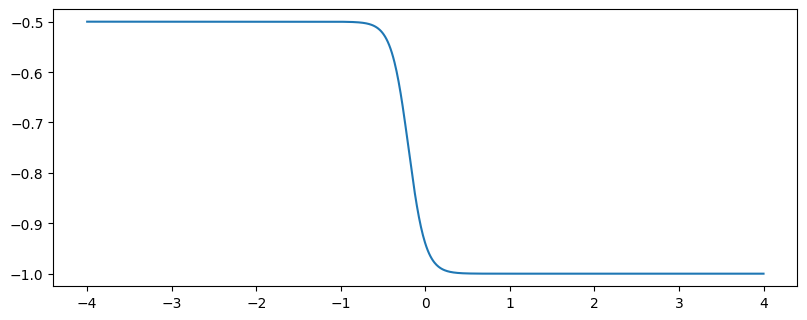

In [52]:
from numpy import exp, linspace

water = 0
depth = linspace( -4, 4, 1000 )
buoyancy = -.5 - .5 / (1 + exp( 10 * (water - depth) - 2 ))

plt.plot( depth, buoyancy )
